In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict


In [ ]:
# Load Karate Club graph
G = nx.karate_club_graph()
n = G.number_of_nodes()
nodes = list(G.nodes())

A = nx.to_numpy_array(G, nodelist=nodes, dtype=int)
k = A.sum(axis=1)
m = int(k.sum()/2)

expected = np.outer(k,k)/(2*m)
B = A - expected

# Leading eigenpair of full B
eigvals, eigvecs = np.linalg.eigh(B)
lambda1 = float(eigvals[-1])
u1 = eigvecs[:,-1]
u1 = u1 / np.linalg.norm(u1)
if u1[np.argmax(np.abs(u1))] < 0:
    u1 = -u1
print("Leading eigenvalue (full B):", lambda1)


Leading eigenvalue (full B): 17.108707741041368


In [ ]:
def leading_eig(Bsub):
    vals, vecs = np.linalg.eigh(Bsub)
    lam = float(vals[-1]); vec = vecs[:,-1]; vec = vec/np.linalg.norm(vec)
    if vec[np.argmax(np.abs(vec))] < 0:
        vec = -vec
    return lam, vec

def deltaQ(Bsub, s, mtotal):
    val = float(s @ (Bsub @ s))
    return val / (4*mtotal)

initial = list(range(n))
stack = [initial]
final_comms = []
accepted = []
itercount = 0

while stack:
    group = stack.pop()
    indices = group
    Bsub = B[np.ix_(indices, indices)]
    lam, vec = leading_eig(Bsub)
    itercount += 1
    s = np.sign(vec); s[s==0]=1
    pos = [indices[i] for i in range(len(indices)) if s[i]>0]
    neg = [indices[i] for i in range(len(indices)) if s[i]<0]
    dq = 0.0
    if len(pos)>0 and len(neg)>0:
        dq = deltaQ(Bsub, s, m)
    if len(pos)>0 and len(neg)>0 and dq>1e-12 and lam>0:
        accepted.append((group,pos,neg,dq))
        stack.append(pos); stack.append(neg)
    else:
        final_comms.append(group)

print("Accepted splits:", len(accepted))
for parent,pos,neg,dq in accepted:
    print(f" parent size {len(parent)} -> {len(pos)} | {len(neg)} ; ΔQ={dq:.6f}")

print("Final communities:", [sorted(c) for c in final_comms])


Accepted splits: 4
 parent size 34 -> 16 | 18 ; ΔQ=0.403628
 parent size 18 -> 15 | 3 ; ΔQ=0.097262
 parent size 3 -> 2 | 1 ; ΔQ=0.005029
 parent size 16 -> 11 | 5 ; ΔQ=0.131800
Final communities: [[9], [8, 30], [14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33], [4, 5, 6, 10, 16], [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]]


In [ ]:
labels = {}
for cid,comm in enumerate(final_comms):
    for node in comm:
        labels[node]=cid
Qtot = 0.0
for i in range(n):
    for j in range(n):
        if labels[i]==labels[j]:
            Qtot += (A[i,j] - (k[i]*k[j])/(2*m))
Qtot = Qtot/(2*m)
print("Final modularity Q =", Qtot)


Final modularity Q = 0.43166357452071746


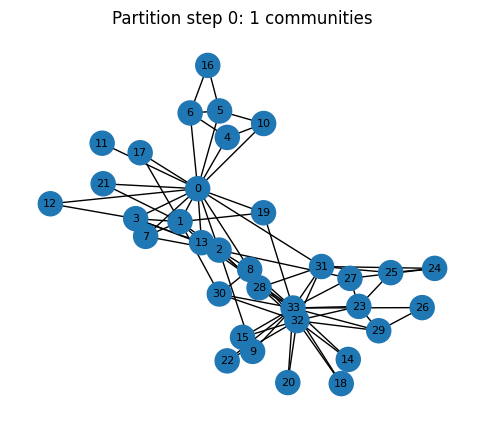

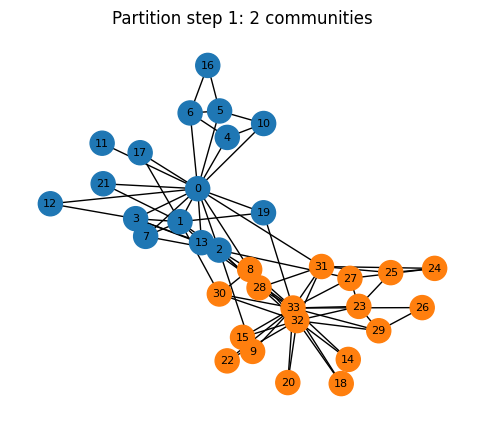

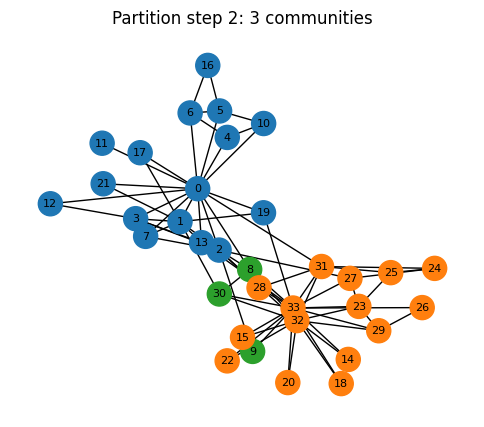

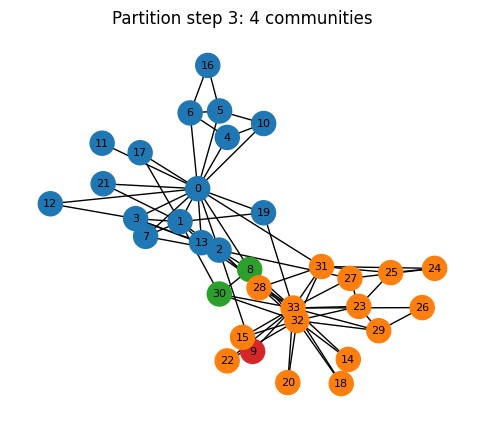

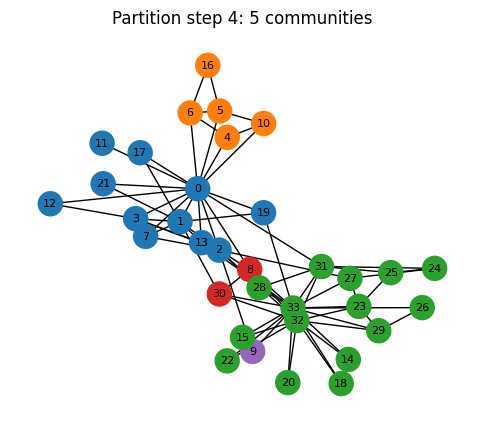

In [ ]:
# Visualize partitions
pos_layout = nx.spring_layout(G, seed=42)
partitions = []
cur = [list(range(n))]
partitions.append(list(cur))
for p,pos,neg,dq in accepted:
    newcur = []
    for block in cur:
        if sorted(block)==sorted(p):
            newcur.append(sorted(pos)); newcur.append(sorted(neg))
        else:
            newcur.append(block)
    cur = newcur
    partitions.append(list(cur))

for idx,part in enumerate(partitions):
    plt.figure(figsize=(6,5))
    cmap = plt.get_cmap("tab10")
    colors = []
    for node in G.nodes():
        cid = next((i for i,b in enumerate(part) if node in b), 0)
        colors.append(cmap(cid%10))
    nx.draw_networkx_nodes(G, pos_layout, node_color=colors, node_size=300)
    nx.draw_networkx_edges(G, pos_layout)
    nx.draw_networkx_labels(G, pos_layout, font_size=8)
    plt.title(f"Partition step {idx}: {len(part)} communities")
    plt.axis('off')
    plt.show()


In [ ]:
# Compute final metrics
deg = nx.degree_centrality(G)
betw = nx.betweenness_centrality(G)
close = nx.closeness_centrality(G)
clust = nx.clustering(G)

df = pd.DataFrame({
    "node": list(range(n)),
    "community": [labels[i] for i in range(n)],
    "degree_centrality": [deg[i] for i in range(n)],
    "betweenness": [betw[i] for i in range(n)],
    "closeness": [close[i] for i in range(n)],
    "clustering": [clust[i] for i in range(n)]
})
df.head()


,node,community,degree_centrality,betweenness,closeness,clustering
0,0,4,0.484848,0.437635,0.568966,0.150000
1,1,4,0.272727,0.053937,0.485294,0.333333
2,2,4,0.303030,0.143657,0.559322,0.244444
3,3,4,0.181818,0.011909,0.464789,0.666667
4,4,3,0.090909,0.000631,0.379310,0.666667
